# Continuous Prior

In my [introduction](Bayes_Primer.ipynb) to Bayes post, I went over a simple application of Bayes theorem to Bernoulli distributed data. In this post, I want to extend our example to use a continous prior.

In my last post, I ended with this code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline
import scipy.stats as st
import seaborn as sns
sns.set(style='ticks', palette='Set2')

def bern_post(n_params=100, n_sample=100, true_p=.8, prior_p=.5, n_prior=100):
    params = np.linspace(0, 1, n_params)
    sample = np.random.binomial(n=1, p=true_p, size=n_sample)
    likelihood = np.array([np.product(st.bernoulli.pmf(sample, p)) for p in params])
    #likelihood = likelihood / np.sum(likelihood)
    prior_sample = np.random.binomial(n=1, p=prior_p, size=n_prior)
    prior = np.array([np.product(st.bernoulli.pmf(prior_sample, p)) for p in params])
    prior = prior / np.sum(prior)
    posterior = [prior[i] * likelihood[i] for i in range(prior.shape[0])]
    posterior = posterior / np.sum(posterior)
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    axes[0].plot(params, likelihood)
    axes[0].set_title("Sampling Distribution")
    axes[1].plot(params, prior)
    axes[1].set_title("Prior Distribution")
    axes[2].plot(params, posterior)
    axes[2].set_title("Posterior Distribution")
    sns.despine()
    plt.tight_layout()
    
    return posterior

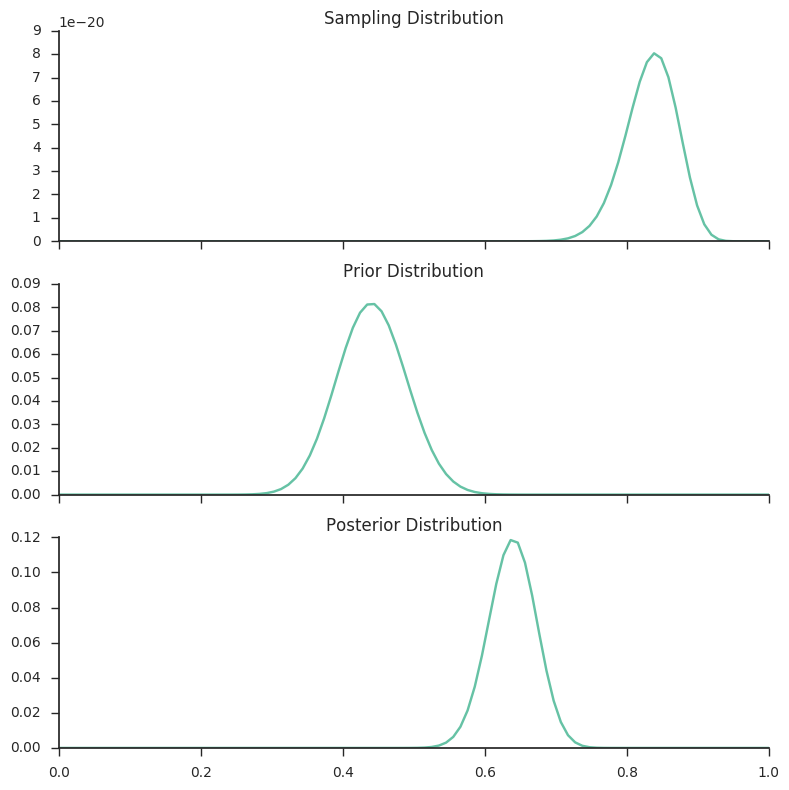

In [2]:
p = bern_post()

You will notice the "n_params" parameter in our code. Remember, in this case we have a prior on the probability of a coin-flip being heads. Thus our prior value has to be between 0 and 1. So n_params = 100 means we split the range 0 to 1 into 100 values. This is typically refered to as a grid approach because we break up our prior value (which can be any real number from 0 to 1) into a finite number of discrete values.

But what if we represent our prior beliefs as a continuous distribution?

# Beta Distribution

So - we need a continuous distribution that gives us a value between 0 and 1 - like our probability of heads. An obvious choice that fits this criteria is a [beta distribution](http://en.wikipedia.org/wiki/Beta_distribution).

What is this beta distribution? Lets take a look:

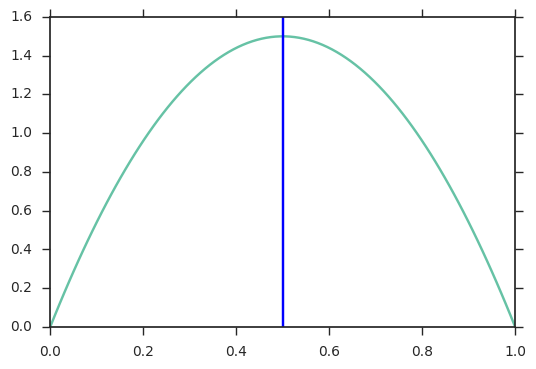

In [3]:
x = np.linspace(0, 1, 100)
y = [st.beta.pdf(x1, 2, 2) for x1 in x]
plt.plot(x, y)
plt.axvline(.5)

If you look closely at the code, you will notice the beta PDF (a PDF is just a function that will tell you the relative likelihood of a random variable to take a given value; so in the above PDF you can see that 0.5 has a relatively high likelihood) takes 2 parameters - we will call them $\alpha$ and $\beta$. With these two parameters we know the PDF of a beta function as: $$\propto x^{\alpha - 1}(1 - x)^{\beta - 1}$$ This formula comes directly from the Wikipedia link. You will notice, though, that I excluded the denominator in the formula. Thus, I said proportional to. In almost all PDF formulas the denominator is the normalizing constant. The normalizing constant is basically what makes sure the PDF integrates to 1 as a probability distribution must. And because it is a constant we can ignore it if we only want relative likelihoods and not actual probability values.

The wikipedia link has a good picture that shows how the PDF of the beta distribution changes as we change $\alpha$ and $\beta$. So how do we pick values for $\alpha$ and $\beta$?

We know (see Wikipedia) that the mean value of a beta PDF is $$\frac{\alpha}{\alpha + \beta}$$ Thus, in our picture above with $\alpha=2$ and $\beta=2$, we get a mean value of .5.

And the variance is: $$\frac{\alpha \beta}{(\alpha + \beta)^{2}(\alpha + \beta + 1)}$$ So for our parameters, we get a value of $$\frac{4}{80}=.05$$ And with a beta distribution, when $\alpha = \beta > 1$ you will always get a symmetric distribution centered around 1/2. This is good for our coin flipping example if we think our prior is a fair coin. As we increase $\alpha$ and $\beta$ our variance will get smaller, which means we have more confidence in our prior belief that our coin is fair.

Note: There are many ways to pick $\alpha$ and $\beta$. Another way I have seen is to:

let $m$ = prior belief of probability of heads

let $n$ = the number of data points used to calculate your $m$ value. If you didn't use data, then basically set $n$ higher if you are more confident in your prior. Then:

$$\alpha = mn$$ $$\beta = (1-m)n$$

In the code below you can see this in action

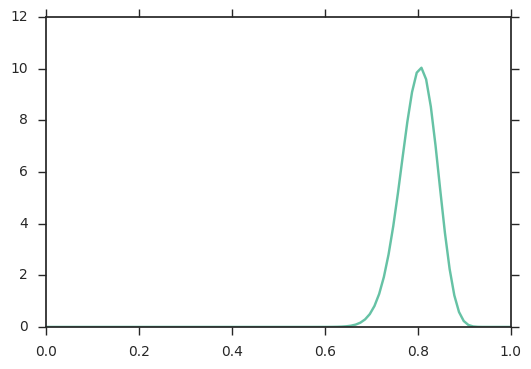

In [4]:
m = .8
n = 100
alpha = m*n
beta = (1-m)*n
y = [st.beta.pdf(x1, alpha, beta) for x1 in x]
plt.plot(x, y)

So what have we learned? 
* Instead of using a grid of values to represent our parameters, we can actually use a continous distribution, like a beta distribution.
* We can specify our prior beta distribution using two parameters: $\alpha$ and $\beta$
* We can adjust $\alpha$ and $\beta$ to more reflect our prior beliefs

## Connecting it all

So how do we use this beta distribution to get to our posterior estimate? Remember: $$p(\theta|y) \propto p(y|\theta)p(\theta)$$ This is basically Bayes' theroem and in English says the posterior distribution is proportional to the product of the likelihood and prior distributions.

Going back to our coin flip example, we defined our likelihood as: $$ \theta^{y}(1-\theta)^{n-y}$$ Where $y$ is the number of flips that are heads, $n$ is the number of total flips, and $\theta$ is the probability of getting a heads.

We will now use a Beta distribution to represent the $p(\theta)$. Thus our prior is: $$\theta^{\alpha-1}(1-\theta)^{\beta-1}$$ 

When we take the product we get: $$ \theta^{y}(1-\theta)^{n-y}\theta^{\alpha-1}(1-\theta)^{\beta-1} $$

Oh! This is nice...we can easily combine terms and get: $$\theta^{y+\alpha-1}(1-\theta)^{n-y+\beta-1} $$

If you add parenthesis in the right places you will see:  $$\theta^{(y+\alpha)-1}(1-\theta)^{(n-y+\beta)-1} $$

Which is just a Beta distribution with $$ \alpha = y + \alpha_{prior} $$ $$ \beta = n - y + \beta_{prior} $$

Wow! This is amazing because now we know exactly how our posterior is distributed. This is so awesome, there is even a name for it: **conjugate prior**. Whenever we have a prior distribution on a likelihood that simplifies to a posterior with the same distribution as the prior, we call that prior distribution a conjugate prior relative to that likelihood distribution. So a beta distribution is a conjugate prior for the bernoulli distribution. (Note: Wikipedia has a great list of [conjugate priors](http://en.wikipedia.org/wiki/Conjugate_prior)) In code:

In [5]:
def bern_beta(n_flips, n_heads, prior_alpha, prior_beta):
    n_tails = n_flips - n_heads
    x_values = np.linspace(0, 1, 100)
    likelihood = [(x**n_heads) * ((1-x)**(n_tails)) for x in x_values]
    prior = [st.beta.pdf(x, prior_alpha, prior_beta) for x in x_values]
    posterior = [st.beta.pdf(x, prior_alpha + n_heads, prior_beta + n_tails) for x in x_values]
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    axes[0].plot(x_values, likelihood)
    axes[0].set_title("Sampling Distribution")
    axes[1].plot(x_values, prior)
    axes[1].set_title("Prior Distribution")
    axes[2].plot(x_values, posterior)
    axes[2].set_title("Posterior Distribution")
    sns.despine()
    plt.tight_layout()

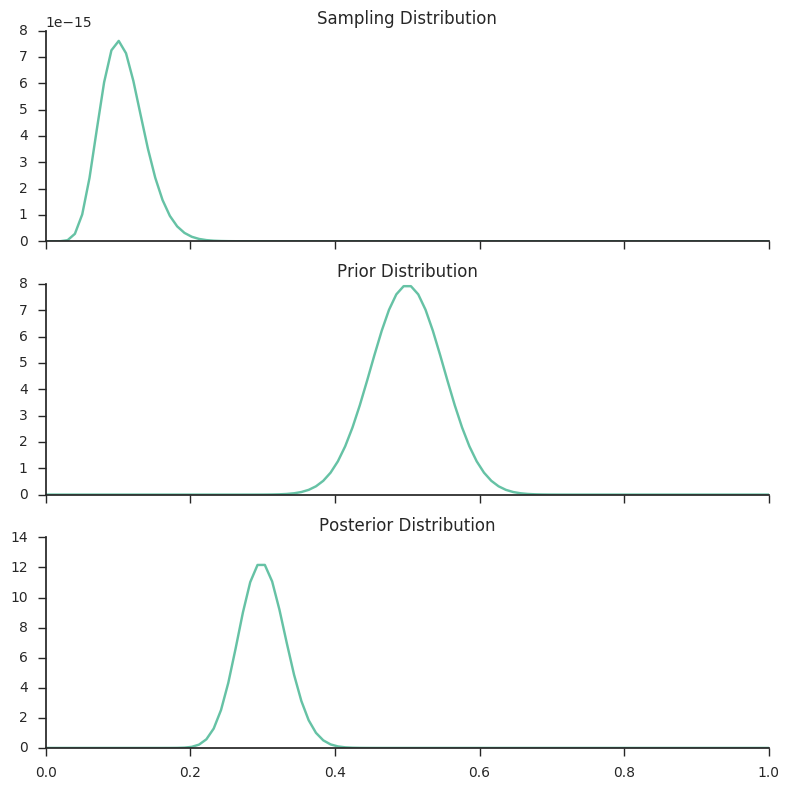

In [6]:
bern_beta(n_flips=100, n_heads=10, prior_alpha=50, prior_beta=50)

## Knowing the Posterior Distribution is Great

Now imagine we only care about the average posterior value. If we make the above assumptions of a bernoulli likelihood and beta prior we know our posterior is distributed as a beta distribution:

$$Beta(y + \alpha_{prior}, n - y + \beta_{prior})$$

And we know the mean value of our beta distribution to be:

$$\frac{y + \alpha_{prior}}{y + \alpha_{prior} + n - y + \beta_{prior}}$$

In [7]:
n = 100
y = 10
prior_alpha = 50
prior_beta = 50
posterior_mean = (y + prior_alpha) / (y + prior_alpha + n - y + prior_beta)
print("Posterior Mean: {}".format(posterior_mean))

Posterior Mean: 0.3


Nice - no need for anything other than some algebra :)